In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch
import difflib
from matplotlib.legend_handler import HandlerBase
from matplotlib import colors
%matplotlib inline

In [2]:
# Activation function
def actfn(x):
    y = x.sigmoid()
    return y

In [3]:
# Size of layers
N = 50
R = 0.8
sizeR = 22

### Getting data from the trained NN

In [4]:
x = torch.tensor(np.genfromtxt(r"Boulder_2019/x_{}.csv".format(N), delimiter=',')).float()
y = torch.tensor(np.genfromtxt(r"Boulder_2019/y_{}.csv".format(N), delimiter=',')).float()
w1 = torch.tensor(np.loadtxt(r"Boulder_2019/Data_25july/weights1_{}_{}.dat".format(N,R)), dtype=torch.float32)
w2 = torch.tensor(np.loadtxt(r"Boulder_2019/Data_25july/weights2_{}_{}.dat".format(N,R)), dtype=torch.float32)
b1 = torch.tensor(np.loadtxt(r"Boulder_2019/Data_25july/bias1_{}_{}.dat".format(N,R)), dtype=torch.float32)
b2 = torch.tensor(np.loadtxt(r"Boulder_2019/Data_25july/bias2_{}_{}.dat".format(N,R)), dtype=torch.float32)

### Adding an activation node in the input layer

In [5]:
activated_units = 1
xp = torch.zeros((N,N+activated_units))
for i in range(len(x)):
    xp[i] = torch.cat((x[i],torch.ones(activated_units,dtype=torch.float32)))

### Original predications of the NN

In [6]:
y_pred = actfn(actfn(x.mm(w1)+b1).mm(w2)+b2)
y_pred = y_pred.detach().numpy()
y_pred = np.abs(np.round(y_pred))  # Threshold = 0.5

### Plots for comparing outputs when hidden neurons are forcefully activated

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


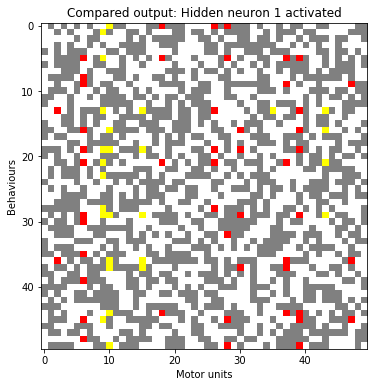

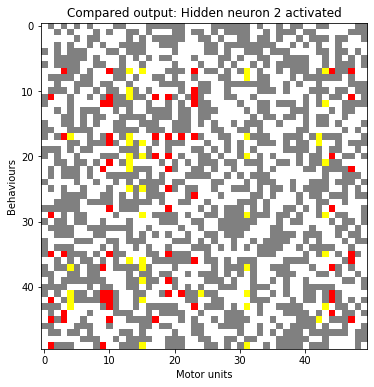

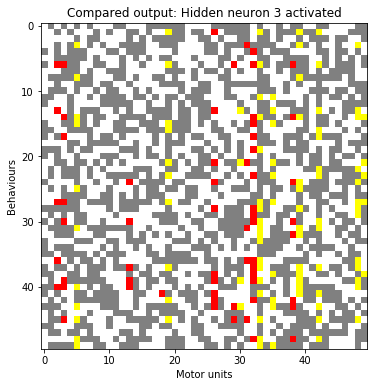

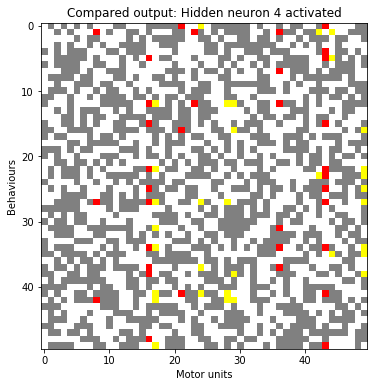

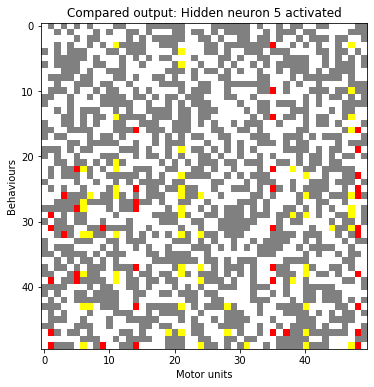

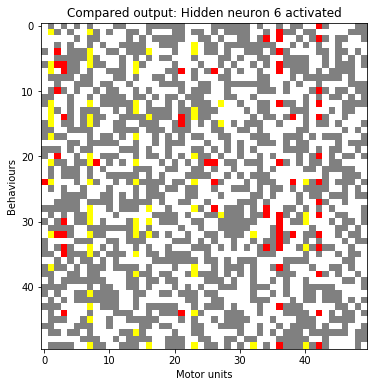

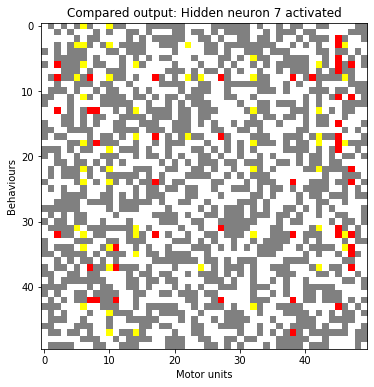

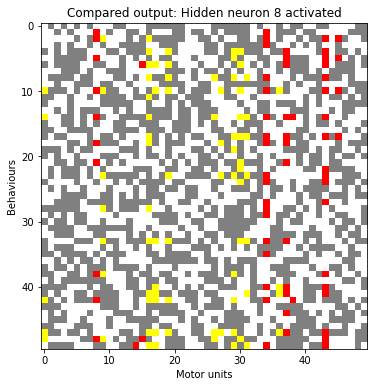

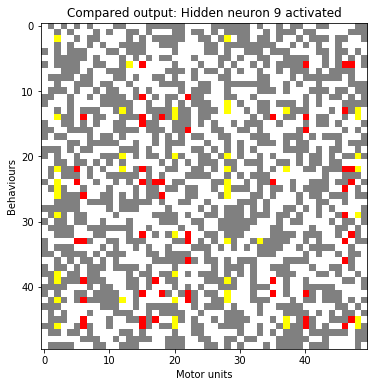

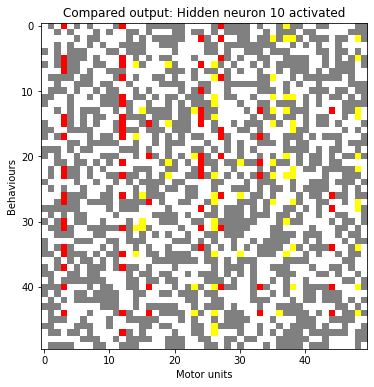

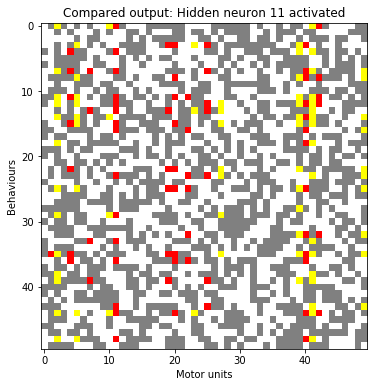

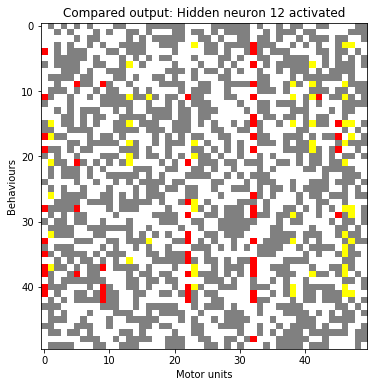

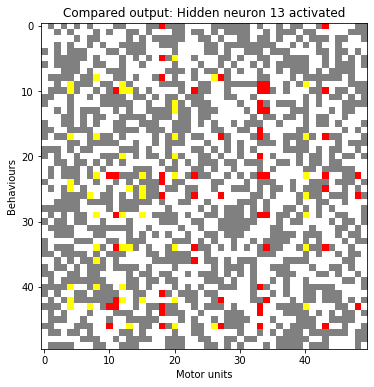

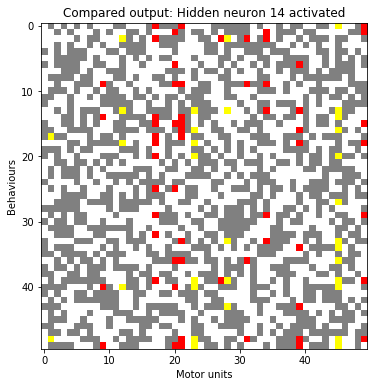

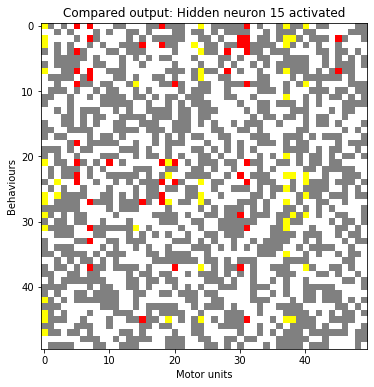

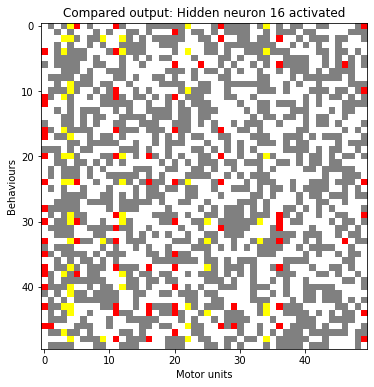

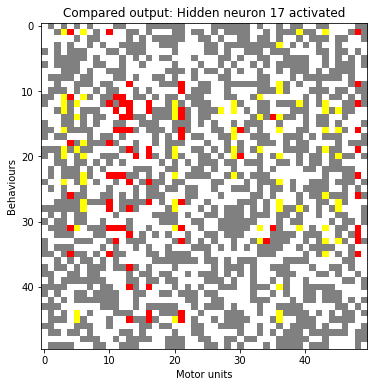

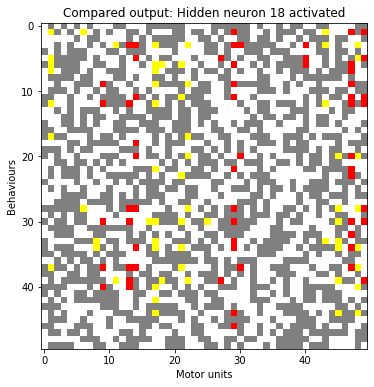

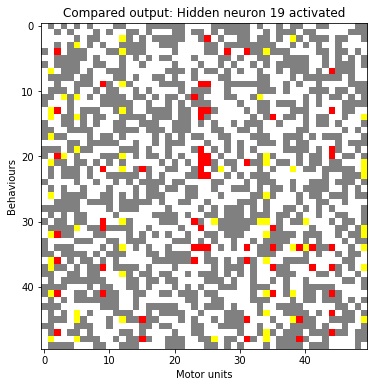

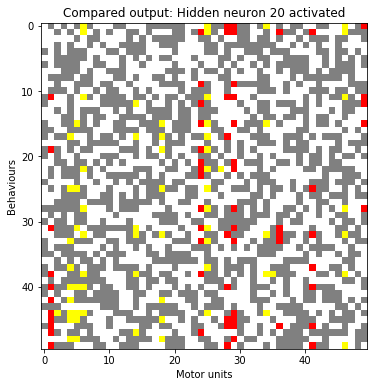

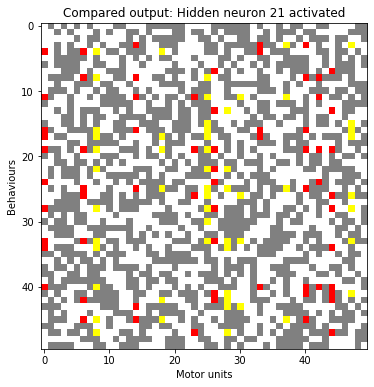

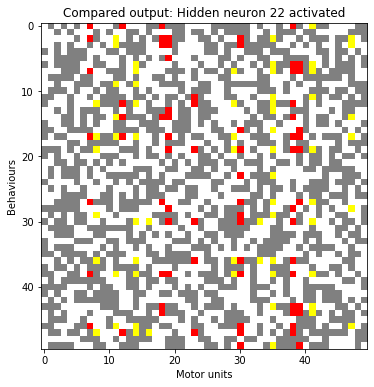

In [7]:
motor_units = [[] for i in range(len(y_pred))] # Which hidden neurons affect each motor unit
hidden_affected = np.zeros(sizeR) # No. of behaviours affected by each hidden neuron

# What happens when each hidden neuron is forcefully always activated.
for i in range(sizeR):
    activated_hidden = torch.zeros(sizeR)
    activated_hidden[i] = 1000
    
    wp = torch.zeros((N+activated_units, sizeR))
    for j in range(len(wp)):
        if j < N:
            wp[j] = w1[j]
        else:
            wp[j] = activated_hidden
            
    # Modified predictions of the NN
    y_pred_2 = actfn(actfn(xp.mm(wp)+b1).mm(w2)+b2)
    y_pred_2 = y_pred_2.detach().numpy()
    y_pred_2 = np.abs(np.round(y_pred_2))  # Threshold = 0.5
    
    # Explicit comparison of the two outputs
    cmap = colors.ListedColormap(['white','red','yellow','grey'])
    # white: Neuron stays off 
    # red: Neuron is turned off
    # Yellow: Neuron is turned on
    # grey: Neuron stays on
    bounds = [0,0.9,1.9,2.9,3.1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    comparison_array = (y_pred_2)*2 + y_pred
    
    for k in range(len(comparison_array)):
        for indx, comp in enumerate(comparison_array[k]):
            if comp == 1 or comp == 2:
                motor_units[indx].append(i+1)
                
    # Number of behaviours each hidden neuron affects
    for k in range(len(comparison_array)):
        for indx, comp in enumerate(comparison_array[k]):
            if comp == 1 or comp == 2:
                hidden_affected[i] += 1
                break
    
    for units in range(len(motor_units)):
        motor_units[units] = list(set(motor_units[units]))
   
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(comparison_array, cmap=cmap, norm=norm)
    plt.xlabel('Motor units')
    plt.ylabel('Behaviours')
    plt.title('Compared output: Hidden neuron {} activated'.format(i+1))   
    #plt.savefig('contextdep1.png')

In [8]:
# Average number of behaviours affected per hidden neuron
avg_affected_behaviours = sum(hidden_affected)/sizeR
avg_affected_behaviours

26.045454545454547

### Code to compute the hamming distance for each output as a function of which hidden neuron is activated

In [34]:
hamming_dist = np.zeros((len(y_pred),sizeR))
for i in range(len(y_pred)):
    for j in range(sizeR):
        activated_hidden = torch.zeros(sizeR)
        activated_hidden[j] = 1000
        
        wp = torch.zeros((N+activated_units, sizeR))
        for k in range(len(wp)):
            if k < N:
                wp[k] = w1[k]
            else:
                wp[k] = activated_hidden
    # Modified predictions of the NN
        y_pred_2 = actfn(actfn(xp.mm(wp)+b1).mm(w2)+b2)
        y_pred_2 = y_pred_2.detach().numpy()
        y_pred_2 = np.abs(np.round(y_pred_2))
        
        hamming_dist[i][j] = np.count_nonzero(y_pred[i]!=y_pred_2[i])        

In [35]:
# Average hamming distance and no. of hidden neurons affecting per behaviour
avg_hamming = []
no_hidden = []
for i in range(len(y_pred)):
    avg_hamming.append(sum(hamming_dist[i]/sizeR))
    no_hidden.append(np.count_nonzero(hamming_dist[i]))

In [18]:
combined_avg = sum(avg_hamming)/N
combined_avg

2.4018181818181814

### Plot of the change in Hamming distance as a function of each hidden neuron for each behaviour

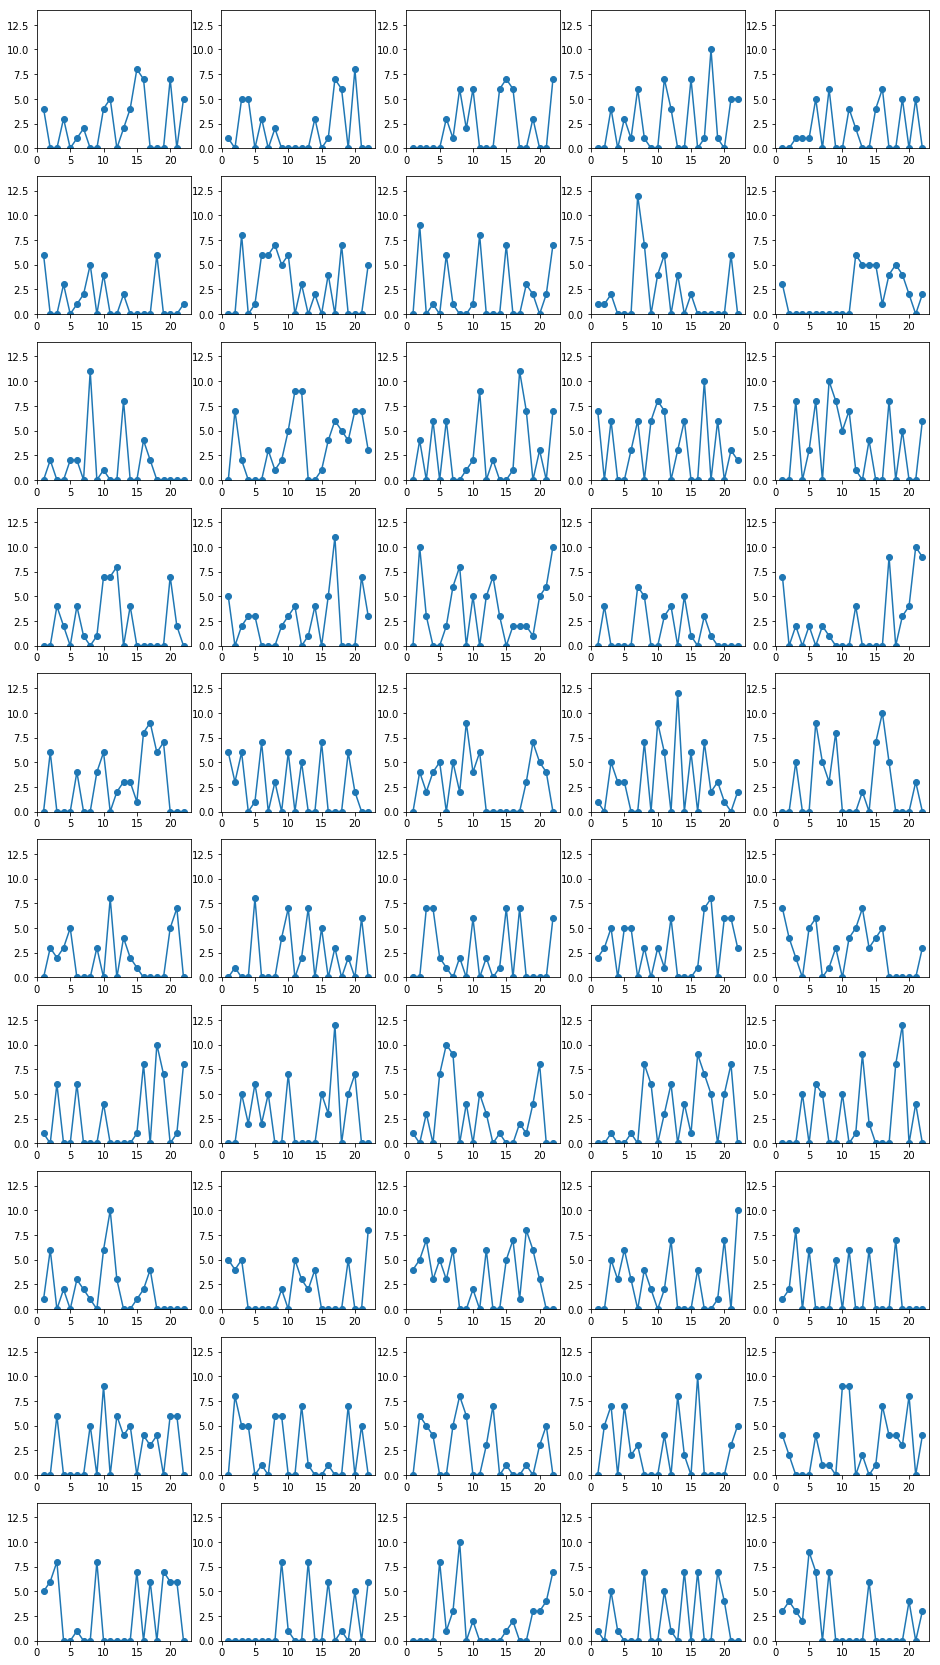

In [19]:
plt.figure(figsize=(16,30))
for i in range(50):
    plt.subplot(10,5,i+1)
    plt.plot(np.arange(1,sizeR+1,1),hamming_dist[i],'o-')
    plt.ylim(0,14)

### Plot of the average hamming distance per behaviour

(0, 1)

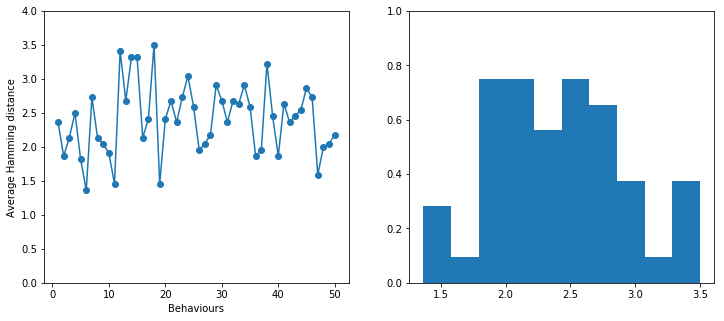

In [36]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.arange(1,len(y_pred)+1,1),avg_hamming,'o-')
#plt.title('Average change in each predicted behaviour')
plt.ylabel('Average Hamming distance')
plt.xlabel('Behaviours')
plt.ylim(0,4)
plt.subplot(1,2,2)
plt.hist(avg_hamming,normed=True)
plt.ylim(0,1)

### Plot of the no. of hidden neurons affecting each behaviour

(array([ 1.,  2.,  2., 11., 13.,  8.,  6.,  2.,  3.,  2.]),
 array([ 7. ,  7.9,  8.8,  9.7, 10.6, 11.5, 12.4, 13.3, 14.2, 15.1, 16. ]),
 <a list of 10 Patch objects>)

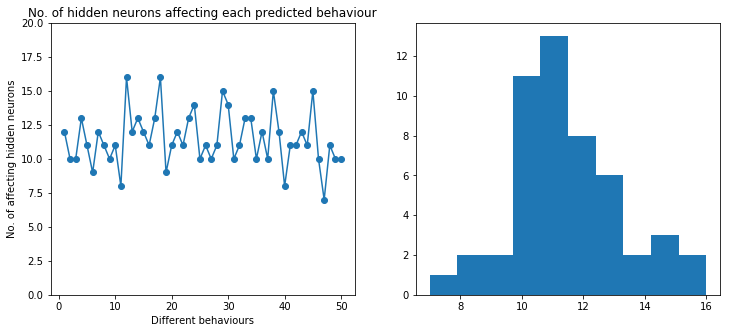

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.arange(1,len(y_pred)+1,1),no_hidden,'o-')
plt.title('No. of hidden neurons affecting each predicted behaviour')
plt.ylabel('No. of affecting hidden neurons')
plt.xlabel('Different behaviours')
plt.ylim(0,20)
plt.subplot(1,2,2)
plt.hist(no_hidden)

### Plot of the robustness of behaviours when hidden neurons are activated

(0, 1)

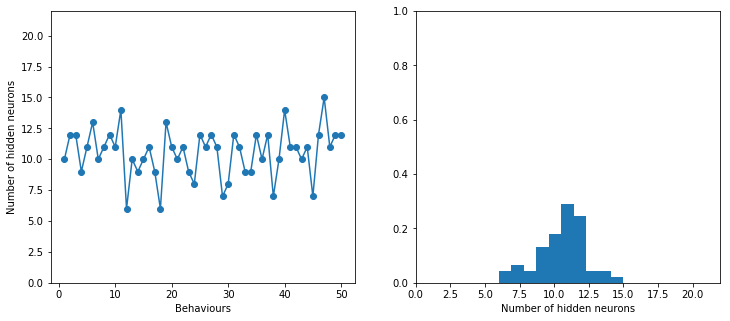

In [37]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.arange(1,len(y_pred)+1,1),sizeR-np.asarray(no_hidden),'o-')
#plt.title('Robustness of behaviour')
plt.ylabel('Number of hidden neurons')
plt.xlabel('Behaviours')
plt.ylim(0,22)
plt.subplot(1,2,2)
plt.hist(sizeR-np.asarray(no_hidden),normed=True)
plt.xlim(0,22)
plt.xlabel('Number of hidden neurons')
plt.ylim(0,1)

### Plot of the no. of hidden units affecting each motor neuron

(0, 22)

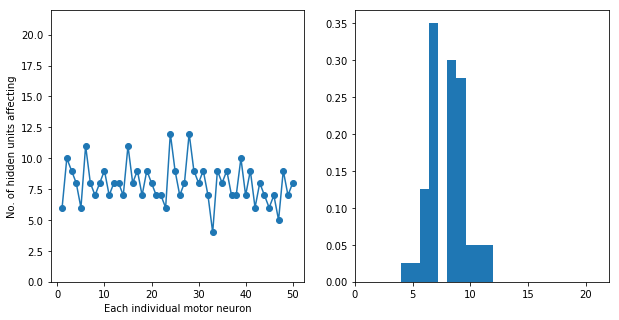

In [26]:
# No. of hidden units affecting each motor neuron
abs_motor = []
for i in range(len(motor_units)):
    abs_motor.append(len(motor_units[i]))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.arange(1,len(motor_units)+1,1),abs_motor,'o-')
plt.ylim(0,22)
plt.xlabel('Each individual motor neuron')
plt.ylabel('No. of hidden units affecting')
plt.subplot(1,2,2)
plt.hist(abs_motor,normed=True)
plt.xlim(0,22)

* Looking at the histogram it seems that this is normally distributed. Which I think makes sense since we have generated the outputs randomly

### Comparing some statistics across different sample sizes

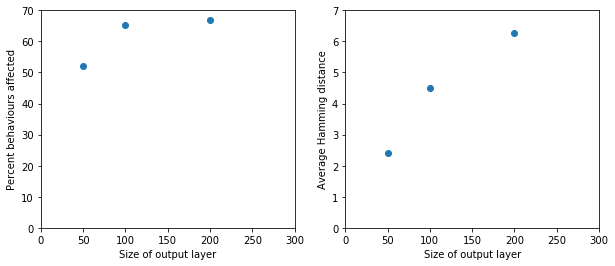

In [52]:
# N = 50,100,200
avg_behaviours = [52,65.36,67] # percent of average number of behaviours affected by 1 hidden neuron at a time
total_avg_hamming = [2.4,4.5,6.28] # avg across behaviours of the hamming distance 
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter([50,100,200],avg_behaviours)
plt.xlim(0,300)
plt.ylim(0,100)
plt.xlabel('Size of output layer')
plt.ylabel('Percent behaviours affected')
plt.subplot(1,2,2)
plt.scatter([50,100,200],total_avg_hamming)
plt.xlim(0,300)
plt.ylim(0,7)
plt.xlabel('Size of output layer')
plt.ylabel('Average Hamming distance')